- Work on CCTV footage at 2 consecutive toll gates, and identify if a vehicle passing through camera 1 (fixed at the 1st toll gate) also passes through camera 2 (at toll gate 2) within a given time window (for instance, if a certain car that crossed toll gate 1 hasn't showed up at the 2nd one within 10-15 minutes, then that car must be flagged for potential suspicion of theft)

- code uses YOLOv8 for vehicle detection and DeepSORT for tracking. It uses the video’s own time (not system time) for matching, and includes visualization

In [2]:
%matplotlib inline

In [3]:
# Install required packages before running:
!pip install ultralytics deep-sort-realtime opencv-python matplotlib

   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------- ----------------------------- 0.3/1.0 MB ? eta -:--:--
   -------------------- ------------------- 0.5/1.0 MB 1.0 MB/s eta 0:00:01
   ------------------------------ --------- 0.8/1.0 MB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 1.0/1.0 MB 1.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/8.4 MB ? eta -:--:--
   ---- ----------------------------------- 1.0/8.4 MB 10.1 MB/s eta 0:00:01
   --------- ------------------------------ 2.1/8.4 MB 5.3 MB/s eta 0:00:02
   ---------------- ----------------------- 3.4/8.4 MB 5.2 MB/s eta 0:00:01
   ---------------------- ----------------- 4.7/8.4 MB 5.4 MB/s eta 0:00:01
   ----------------------------- ---------- 6.3/8.4 MB 5.8 MB/s eta 0:00:01
   ------------------------------------ --- 7.6/8.4 MB 5.9 MB/s eta 0:00:01
   ------------------------------------


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import cv2
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
import matplotlib.pyplot as plt
from IPython.display import clear_output  # For Jupyter notebook cleanup

# Initialize YOLOv8 model
model = YOLO("yolov8n.pt")  # Automatically downloads if missing

# Initialize DeepSORT trackers
tracker1 = DeepSort(max_age=30)
tracker2 = DeepSort(max_age=30)

# Vehicle tracking dictionaries
toll1_exits = {}
toll2_exits = {}
suspicious_vehicles = []

def process_video(video_path, tracker, toll_gate=1):
    cap = cv2.VideoCapture(video_path)
    fig = plt.figure(figsize=(10, 6))  # Initialize figure once
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Vehicle detection
        detections = model(frame)[0]
        results = []
        for box in detections.boxes:
            label = model.names[int(box.cls)]
            conf = float(box.conf)
            if label in ["car", "bus", "truck", "motorcycle"] and conf > 0.4:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                results.append([[x1, y1, x2-x1, y2-y1], conf, label])

        # Vehicle tracking
        tracks = tracker.update_tracks(results, frame=frame)

        # Annotate frame
        for track in tracks:
            if not track.is_confirmed():
                continue
            track_id = track.track_id
            ltrb = track.to_ltrb()
            x1, y1, x2, y2 = map(int, ltrb)
            
            # Draw bounding box and ID
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, f'ID:{track_id}', (x1, y1-10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

            # Detect exits (right 15% of frame)
            if x2 > frame.shape[1] * 0.85:
                current_time = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000
                if toll_gate == 1:
                    toll1_exits[track_id] = current_time
                else:
                    toll2_exits[track_id] = current_time

        # Display using matplotlib (for notebooks)
        clear_output(wait=True)  # For Jupyter notebook
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f'Toll Gate {toll_gate} Monitoring')
        plt.show()
        plt.pause(0.001)  # Needed for frame updates

    cap.release()
    plt.close(fig)

def find_suspicious_vehicles(time_window=15):
    """
    Improved matching logic with bidirectional checking
    """
    global suspicious_vehicles
    
    # Check vehicles from toll1 not in toll2 within window
    for vid, t1_time in toll1_exits.items():
        if not any((0 < (t2_time - t1_time)/60 <= time_window) 
                   for t2_time in toll2_exits.values()):
            suspicious_vehicles.append(vid)
    
    # Check vehicles from toll2 not in toll1 within window
    for vid, t2_time in toll2_exits.items():
        if not any((0 < (t2_time - t1_time)/60 <= time_window) 
                   for t1_time in toll1_exits.values()):
            suspicious_vehicles.append(vid)

c:\Users\afzal\AppData\Local\Programs\Python\Python312\Lib\site-packages\deep_sort_realtime\embedder\embedder_pytorch.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


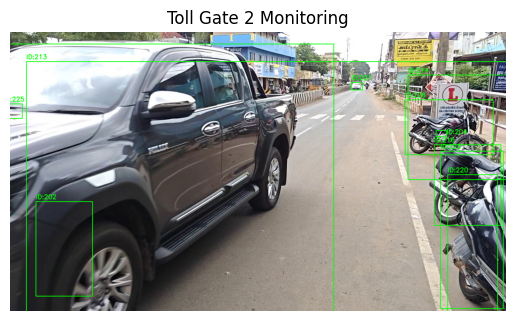

Suspicious vehicles not appearing within time window: ['3', '5', '1', '8', '11', '14', '3', '5', '1', '8', '11', '14', '64', '90', '91', '64', '88', '32', '64', '88', '32', '64', '88', '32', '64', '88', '32', '165', '32', '171', '32', '193', '112', '193', '112', '193', '112', '193', '112', '193', '112', '193', '112']


In [19]:
# Main Execution

# Process your videos (replace with your actual filenames)
process_video(r"C:\Users\afzal\Downloads\VehicleIVideos\BlackCarFront.mp4", tracker1, toll_gate=1)
# Depending on your use case, you might want to process videos sequentially
# or find a way to manage the displays from two separate calls to process_video
# simultaneously, which might be complex in a notebook environment.
# For simple visualization, running them one after the other might be necessary.
process_video(r"C:\Users\afzal\Downloads\VehicleIVideos\BlackCarFront.mp4", tracker2, toll_gate=2)


# Analyze results
# Note: If you process videos sequentially without clearing the exit dictionaries,
# the results from the second video process might not be correctly associated
# with the first. You might need a different approach if you're processing two
# separate videos representing two gates. If it's one video with two distinct areas
# representing gates, the logic for distinguishing them within one video is missing.
find_suspicious_vehicles(time_window=15)

# Output suspicious vehicles
print(f"Suspicious vehicles not appearing within time window: {suspicious_vehicles}")

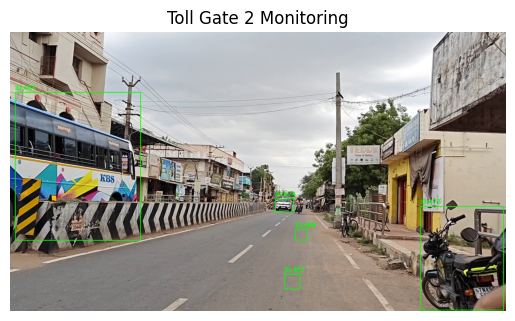

Suspicious vehicles not appearing within time window: ['3', '5', '1', '8', '11', '14', '3', '5', '1', '8', '11', '14', '64', '90', '91', '64', '88', '32', '64', '88', '32', '64', '88', '32', '64', '88', '32', '165', '32', '171', '32', '193', '112', '193', '112', '193', '112', '193', '112', '193', '112', '193', '112', '532', '112']


In [20]:
# Main Execution

# Process your videos (replace with your actual filenames)
process_video(r"C:\Users\afzal\Downloads\VehicleIVideos\ForYouMultipleVehicles.mp4", tracker1, toll_gate=1)
# Depending on your use case, you might want to process videos sequentially
# or find a way to manage the displays from two separate calls to process_video
# simultaneously, which might be complex in a notebook environment.
# For simple visualization, running them one after the other might be necessary.
process_video(r"C:\Users\afzal\Downloads\VehicleIVideos\ForYouMultipleVehicles.mp4", tracker2, toll_gate=2)


# Analyze results
# Note: If you process videos sequentially without clearing the exit dictionaries,
# the results from the second video process might not be correctly associated
# with the first. You might need a different approach if you're processing two
# separate videos representing two gates. If it's one video with two distinct areas
# representing gates, the logic for distinguishing them within one video is missing.
find_suspicious_vehicles(time_window=15)

# Output suspicious vehicles
print(f"Suspicious vehicles not appearing within time window: {suspicious_vehicles}")

# plt.close('all')  # After processing each video

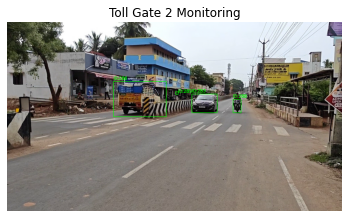

In [ ]:
# Main Execution

# Process your videos (replace with your actual filenames)
process_video(r"C:\Users\afzal\Downloads\VehicleIVideos\MultipleVehicles.mp4", tracker1, toll_gate=1)
# Depending on your use case, you might want to process videos sequentially
# or find a way to manage the displays from two separate calls to process_video
# simultaneously, which might be complex in a notebook environment.
# For simple visualization, running them one after the other might be necessary.
process_video(r"C:\Users\afzal\Downloads\VehicleIVideos\MultipleVehicles.mp4", tracker2, toll_gate=2)


# Analyze results
# Note: If you process videos sequentially without clearing the exit dictionaries,
# the results from the second video process might not be correctly associated
# with the first. You might need a different approach if you're processing two
# separate videos representing two gates. If it's one video with two distinct areas
# representing gates, the logic for distinguishing them within one video is missing.
find_suspicious_vehicles(time_window=15)

# Output suspicious vehicles
print(f"Suspicious vehicles not appearing within time window: {suspicious_vehicles}")

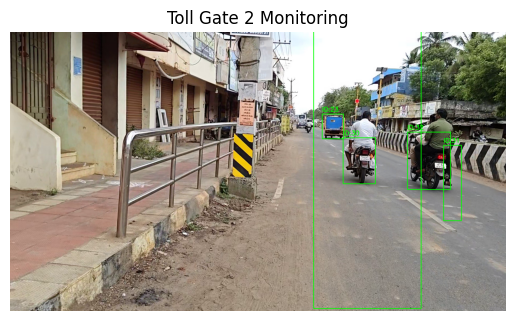

Suspicious vehicles not appearing within time window: ['3', '5', '1', '8', '11', '14', '3', '5', '1', '8', '11', '14', '64', '90', '91']


In [7]:
# Main Execution

# Process your videos (replace with your actual filenames)
process_video(r"C:\Users\afzal\Downloads\VehicleIVideos\MultipleVehiclesBack.mp4", tracker1, toll_gate=1)
# Depending on your use case, you might want to process videos sequentially
# or find a way to manage the displays from two separate calls to process_video
# simultaneously, which might be complex in a notebook environment.
# For simple visualization, running them one after the other might be necessary.
process_video(r"C:\Users\afzal\Downloads\VehicleIVideos\MultipleVehiclesBack.mp4", tracker2, toll_gate=2)


# Analyze results
# Note: If you process videos sequentially without clearing the exit dictionaries,
# the results from the second video process might not be correctly associated
# with the first. You might need a different approach if you're processing two
# separate videos representing two gates. If it's one video with two distinct areas
# representing gates, the logic for distinguishing them within one video is missing.
find_suspicious_vehicles(time_window=15)

# Output suspicious vehicles
print(f"Suspicious vehicles not appearing within time window: {suspicious_vehicles}")

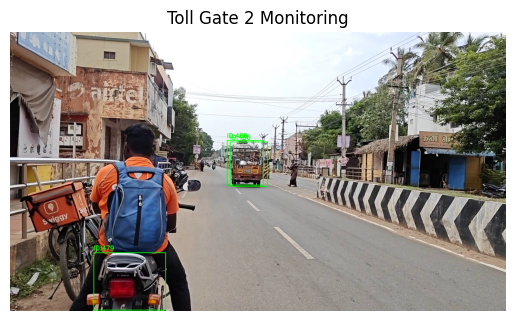

Suspicious vehicles not appearing within time window: ['3', '5', '1', '8', '11', '14', '3', '5', '1', '8', '11', '14', '64', '90', '91', '64', '88', '32', '64', '88', '32', '64', '88', '32', '64', '88', '32', '165', '32', '171', '32', '193', '112', '193', '112', '193', '112', '193', '112', '193', '112', '193', '112', '532', '112', '520', '112', '520', '112']


In [22]:
# Main Execution

# Process your videos (replace with your actual filenames)
process_video(r"C:\Users\afzal\Downloads\VehicleIVideos\TataAceBack.mp4", tracker1, toll_gate=1)
# Depending on your use case, you might want to process videos sequentially
# or find a way to manage the displays from two separate calls to process_video
# simultaneously, which might be complex in a notebook environment.
# For simple visualization, running them one after the other might be necessary.
process_video(r"C:\Users\afzal\Downloads\VehicleIVideos\TataAceBack.mp4", tracker2, toll_gate=2)


# Analyze results
# Note: If you process videos sequentially without clearing the exit dictionaries,
# the results from the second video process might not be correctly associated
# with the first. You might need a different approach if you're processing two
# separate videos representing two gates. If it's one video with two distinct areas
# representing gates, the logic for distinguishing them within one video is missing.
find_suspicious_vehicles(time_window=15)

# Output suspicious vehicles
print(f"Suspicious vehicles not appearing within time window: {suspicious_vehicles}")

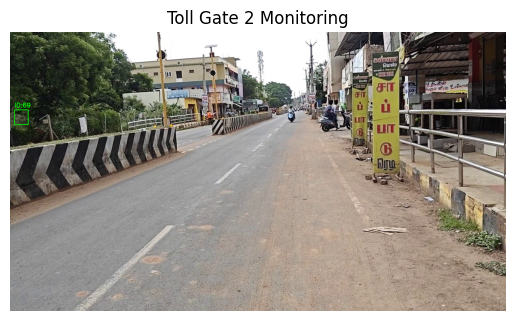

Suspicious vehicles not appearing within time window: ['3', '5', '1', '8', '11', '14', '3', '5', '1', '8', '11', '14', '64', '90', '91', '64', '88', '32', '64', '88', '32']


In [9]:
# Main Execution

# Process your videos (replace with your actual filenames)
process_video(r"C:\Users\afzal\Downloads\VehicleIVideos\MultipleVehiclesFront.mp4", tracker1, toll_gate=1)
# Depending on your use case, you might want to process videos sequentially
# or find a way to manage the displays from two separate calls to process_video
# simultaneously, which might be complex in a notebook environment.
# For simple visualization, running them one after the other might be necessary.
process_video(r"C:\Users\afzal\Downloads\VehicleIVideos\MultipleVehiclesFront.mp4", tracker2, toll_gate=2)


# Analyze results
# Note: If you process videos sequentially without clearing the exit dictionaries,
# the results from the second video process might not be correctly associated
# with the first. You might need a different approach if you're processing two
# separate videos representing two gates. If it's one video with two distinct areas
# representing gates, the logic for distinguishing them within one video is missing.
find_suspicious_vehicles(time_window=15)

# Output suspicious vehicles
print(f"Suspicious vehicles not appearing within time window: {suspicious_vehicles}")

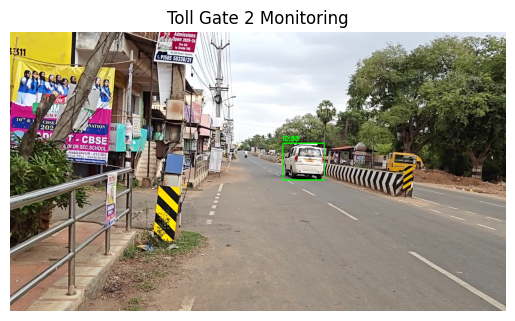

Suspicious vehicles not appearing within time window: ['3', '5', '1', '8', '11', '14', '3', '5', '1', '8', '11', '14', '64', '90', '91', '64', '88', '32', '64', '88', '32', '64', '88', '32']


In [10]:
# Main Execution

# Process your videos (replace with your actual filenames)
process_video(r"C:\Users\afzal\Downloads\VehicleIVideos\WhiteCarBack.mp4", tracker1, toll_gate=1)
# Depending on your use case, you might want to process videos sequentially
# or find a way to manage the displays from two separate calls to process_video
# simultaneously, which might be complex in a notebook environment.
# For simple visualization, running them one after the other might be necessary.
process_video(r"C:\Users\afzal\Downloads\VehicleIVideos\WhiteCarBack.mp4", tracker2, toll_gate=2)


# Analyze results
# Note: If you process videos sequentially without clearing the exit dictionaries,
# the results from the second video process might not be correctly associated
# with the first. You might need a different approach if you're processing two
# separate videos representing two gates. If it's one video with two distinct areas
# representing gates, the logic for distinguishing them within one video is missing.
find_suspicious_vehicles(time_window=15)

# Output suspicious vehicles
print(f"Suspicious vehicles not appearing within time window: {suspicious_vehicles}")

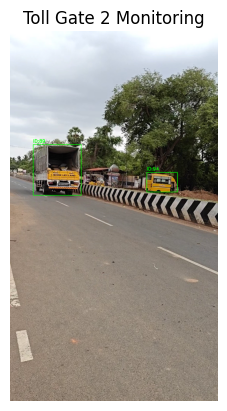

Suspicious vehicles not appearing within time window: ['3', '5', '1', '8', '11', '14', '3', '5', '1', '8', '11', '14', '64', '90', '91', '64', '88', '32', '64', '88', '32', '64', '88', '32', '64', '88', '32']


In [11]:
# Main Execution

# Process your videos (replace with your actual filenames)
process_video(r"C:\Users\afzal\Downloads\VehicleIVideos\TruckBack.mp4", tracker1, toll_gate=1)
# Depending on your use case, you might want to process videos sequentially
# or find a way to manage the displays from two separate calls to process_video
# simultaneously, which might be complex in a notebook environment.
# For simple visualization, running them one after the other might be necessary.
process_video(r"C:\Users\afzal\Downloads\VehicleIVideos\TruckBack.mp4", tracker2, toll_gate=2)


# Analyze results
# Note: If you process videos sequentially without clearing the exit dictionaries,
# the results from the second video process might not be correctly associated
# with the first. You might need a different approach if you're processing two
# separate videos representing two gates. If it's one video with two distinct areas
# representing gates, the logic for distinguishing them within one video is missing.
find_suspicious_vehicles(time_window=15)

# Output suspicious vehicles
print(f"Suspicious vehicles not appearing within time window: {suspicious_vehicles}")

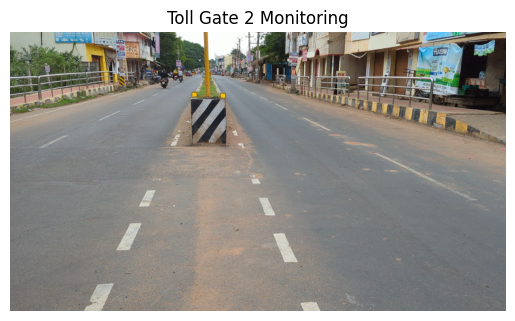

Suspicious vehicles not appearing within time window: ['3', '5', '1', '8', '11', '14', '3', '5', '1', '8', '11', '14', '64', '90', '91', '64', '88', '32', '64', '88', '32', '64', '88', '32', '64', '88', '32', '165', '32']


In [12]:
# Main Execution

# Process your videos (replace with your actual filenames)
process_video(r"C:\Users\afzal\Downloads\VehicleIVideos\PXL_Bikes.mp4", tracker1, toll_gate=1)
# Depending on your use case, you might want to process videos sequentially
# or find a way to manage the displays from two separate calls to process_video
# simultaneously, which might be complex in a notebook environment.
# For simple visualization, running them one after the other might be necessary.
process_video(r"C:\Users\afzal\Downloads\VehicleIVideos\PXL_Bikes.mp4", tracker2, toll_gate=2)


# Analyze results
# Note: If you process videos sequentially without clearing the exit dictionaries,
# the results from the second video process might not be correctly associated
# with the first. You might need a different approach if you're processing two
# separate videos representing two gates. If it's one video with two distinct areas
# representing gates, the logic for distinguishing them within one video is missing.
find_suspicious_vehicles(time_window=15)

# Output suspicious vehicles
print(f"Suspicious vehicles not appearing within time window: {suspicious_vehicles}")

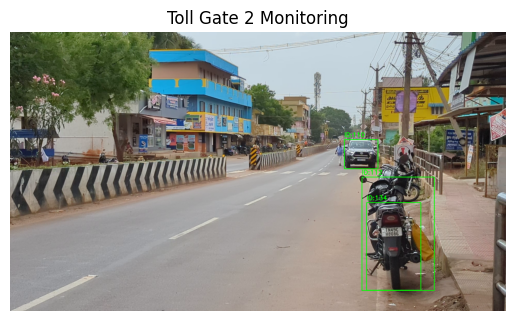

Suspicious vehicles not appearing within time window: ['3', '5', '1', '8', '11', '14', '3', '5', '1', '8', '11', '14', '64', '90', '91', '64', '88', '32', '64', '88', '32', '64', '88', '32', '64', '88', '32', '165', '32', '171', '32']


In [13]:
# Main Execution

# Process your videos (replace with your actual filenames)
process_video(r"C:\Users\afzal\Downloads\VehicleIVideos\PXL_BikesWhiteCarFront.mp4", tracker1, toll_gate=1)
# Depending on your use case, you might want to process videos sequentially
# or find a way to manage the displays from two separate calls to process_video
# simultaneously, which might be complex in a notebook environment.
# For simple visualization, running them one after the other might be necessary.
process_video(r"C:\Users\afzal\Downloads\VehicleIVideos\PXL_BikesWhiteCarFront.mp4", tracker2, toll_gate=2)


# Analyze results
# Note: If you process videos sequentially without clearing the exit dictionaries,
# the results from the second video process might not be correctly associated
# with the first. You might need a different approach if you're processing two
# separate videos representing two gates. If it's one video with two distinct areas
# representing gates, the logic for distinguishing them within one video is missing.
find_suspicious_vehicles(time_window=15)

# Output suspicious vehicles
print(f"Suspicious vehicles not appearing within time window: {suspicious_vehicles}")

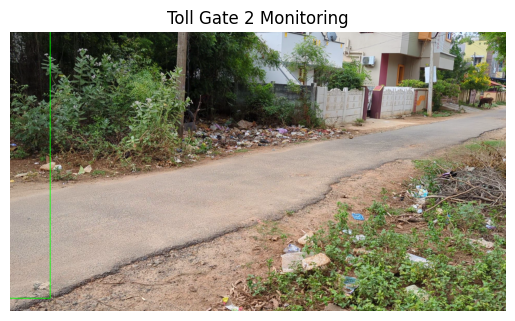

Suspicious vehicles not appearing within time window: ['3', '5', '1', '8', '11', '14', '3', '5', '1', '8', '11', '14', '64', '90', '91', '64', '88', '32', '64', '88', '32', '64', '88', '32', '64', '88', '32', '165', '32', '171', '32', '193', '112']


In [14]:
# Main Execution

# Process your videos (replace with your actual filenames)
process_video(r"C:\Users\afzal\Downloads\VehicleIVideos\PXL_Auto.mp4", tracker1, toll_gate=1)
# Depending on your use case, you might want to process videos sequentially
# or find a way to manage the displays from two separate calls to process_video
# simultaneously, which might be complex in a notebook environment.
# For simple visualization, running them one after the other might be necessary.
process_video(r"C:\Users\afzal\Downloads\VehicleIVideos\PXL_Auto.mp4", tracker2, toll_gate=2)


# Analyze results
# Note: If you process videos sequentially without clearing the exit dictionaries,
# the results from the second video process might not be correctly associated
# with the first. You might need a different approach if you're processing two
# separate videos representing two gates. If it's one video with two distinct areas
# representing gates, the logic for distinguishing them within one video is missing.
find_suspicious_vehicles(time_window=15)

# Output suspicious vehicles
print(f"Suspicious vehicles not appearing within time window: {suspicious_vehicles}")

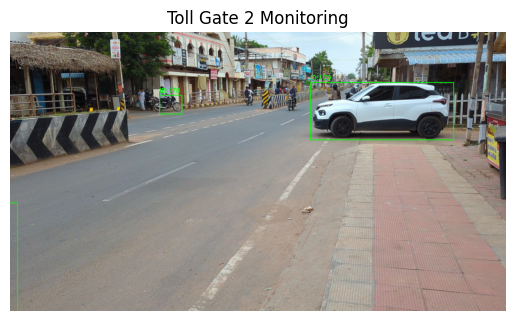

Suspicious vehicles not appearing within time window: ['3', '5', '1', '8', '11', '14', '3', '5', '1', '8', '11', '14', '64', '90', '91', '64', '88', '32', '64', '88', '32', '64', '88', '32', '64', '88', '32', '165', '32', '171', '32', '193', '112', '193', '112']


In [15]:
# Main Execution

# Process your videos (replace with your actual filenames)
process_video(r"C:\Users\afzal\Downloads\VehicleIVideos\PXL_BikeFront.mp4", tracker1, toll_gate=1)
# Depending on your use case, you might want to process videos sequentially
# or find a way to manage the displays from two separate calls to process_video
# simultaneously, which might be complex in a notebook environment.
# For simple visualization, running them one after the other might be necessary.
process_video(r"C:\Users\afzal\Downloads\VehicleIVideos\PXL_BikeFront.mp4", tracker2, toll_gate=2)


# Analyze results
# Note: If you process videos sequentially without clearing the exit dictionaries,
# the results from the second video process might not be correctly associated
# with the first. You might need a different approach if you're processing two
# separate videos representing two gates. If it's one video with two distinct areas
# representing gates, the logic for distinguishing them within one video is missing.
find_suspicious_vehicles(time_window=15)

# Output suspicious vehicles
print(f"Suspicious vehicles not appearing within time window: {suspicious_vehicles}")

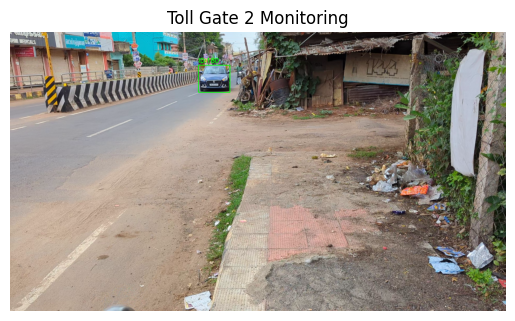

Suspicious vehicles not appearing within time window: ['3', '5', '1', '8', '11', '14', '3', '5', '1', '8', '11', '14', '64', '90', '91', '64', '88', '32', '64', '88', '32', '64', '88', '32', '64', '88', '32', '165', '32', '171', '32', '193', '112', '193', '112', '193', '112']


In [16]:
# Main Execution

# Process your videos (replace with your actual filenames)
process_video(r"C:\Users\afzal\Downloads\VehicleIVideos\PXL_BlackCarFront.mp4", tracker1, toll_gate=1)
# Depending on your use case, you might want to process videos sequentially
# or find a way to manage the displays from two separate calls to process_video
# simultaneously, which might be complex in a notebook environment.
# For simple visualization, running them one after the other might be necessary.
process_video(r"C:\Users\afzal\Downloads\VehicleIVideos\PXL_BlackCarFront.mp4", tracker2, toll_gate=2)


# Analyze results
# Note: If you process videos sequentially without clearing the exit dictionaries,
# the results from the second video process might not be correctly associated
# with the first. You might need a different approach if you're processing two
# separate videos representing two gates. If it's one video with two distinct areas
# representing gates, the logic for distinguishing them within one video is missing.
find_suspicious_vehicles(time_window=15)

# Output suspicious vehicles
print(f"Suspicious vehicles not appearing within time window: {suspicious_vehicles}")

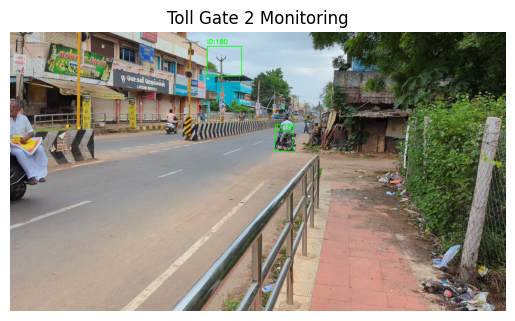

Suspicious vehicles not appearing within time window: ['3', '5', '1', '8', '11', '14', '3', '5', '1', '8', '11', '14', '64', '90', '91', '64', '88', '32', '64', '88', '32', '64', '88', '32', '64', '88', '32', '165', '32', '171', '32', '193', '112', '193', '112', '193', '112', '193', '112']


In [17]:
# Main Execution

# Process your videos (replace with your actual filenames)
process_video(r"C:\Users\afzal\Downloads\VehicleIVideos\PXL_SplitSecond.mp4", tracker1, toll_gate=1)
# Depending on your use case, you might want to process videos sequentially
# or find a way to manage the displays from two separate calls to process_video
# simultaneously, which might be complex in a notebook environment.
# For simple visualization, running them one after the other might be necessary.
process_video(r"C:\Users\afzal\Downloads\VehicleIVideos\PXL_SplitSecond.mp4", tracker2, toll_gate=2)


# Analyze results
# Note: If you process videos sequentially without clearing the exit dictionaries,
# the results from the second video process might not be correctly associated
# with the first. You might need a different approach if you're processing two
# separate videos representing two gates. If it's one video with two distinct areas
# representing gates, the logic for distinguishing them within one video is missing.
find_suspicious_vehicles(time_window=15)

# Output suspicious vehicles
print(f"Suspicious vehicles not appearing within time window: {suspicious_vehicles}")

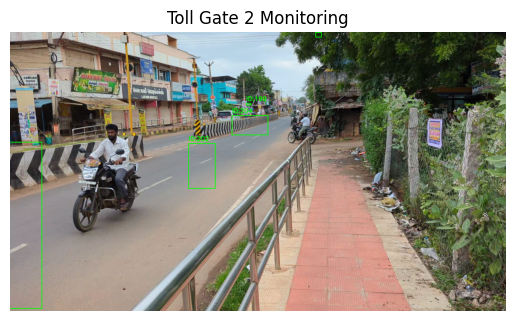

Suspicious vehicles not appearing within time window: ['3', '5', '1', '8', '11', '14', '3', '5', '1', '8', '11', '14', '64', '90', '91', '64', '88', '32', '64', '88', '32', '64', '88', '32', '64', '88', '32', '165', '32', '171', '32', '193', '112', '193', '112', '193', '112', '193', '112', '193', '112']


In [18]:
# Main Execution

# Process your videos (replace with your actual filenames)
process_video(r"C:\Users\afzal\Downloads\VehicleIVideos\PXL_TimeLapse.mp4", tracker1, toll_gate=1)
# Depending on your use case, you might want to process videos sequentially
# or find a way to manage the displays from two separate calls to process_video
# simultaneously, which might be complex in a notebook environment.
# For simple visualization, running them one after the other might be necessary.
process_video(r"C:\Users\afzal\Downloads\VehicleIVideos\PXL_TimeLapse.mp4", tracker2, toll_gate=2)


# Analyze results
# Note: If you process videos sequentially without clearing the exit dictionaries,
# the results from the second video process might not be correctly associated
# with the first. You might need a different approach if you're processing two
# separate videos representing two gates. If it's one video with two distinct areas
# representing gates, the logic for distinguishing them within one video is missing.
find_suspicious_vehicles(time_window=15)

# Output suspicious vehicles
print(f"Suspicious vehicles not appearing within time window: {suspicious_vehicles}")